# Social Network Analysis of Leviticus 17-26

This notebook combines the participant references and semantic roles computed in other phases of this research project. The two datatypes are combined to create a social network model of the data and to explore this model by social network analytical tools. The first SNA-measures are given in this notobook, while more detailed studies of participant roles are reserved for other notebooks in this repo.

**Content**
1. Import of data
2. Cross-tabulating participant and semantic roles
3. Creation of network model
4. Validation of the model
5. First social network analyses

In [1]:
#Dataset path
PATH = 'datasets/'

import csv, collections, html
from operator import itemgetter
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import networkx as nx
import forceatlas2
import random

##  1. Import data

In [ ]:
#Importing the Hebrew data and Text-Fabric
from tf.app import use
A = use('etcbc/bhsa', hoist=globals(), mod='etcbc/heads/tf')

#### 1.a Import of participant reference data:

In [ ]:
df = pd.read_csv(f'{PATH}participants_FINAL.csv')
df.columns = ['participant','refs']
df.head()

The references are transformed to lists and their respective frequencies in the corpus are counted 

In [ ]:
ref_list = []
participant_freq = []

for row in df.iterrows():
    refs = [int(r) for r in row[1].refs.split()]
    ref_list.append(refs)
    participant_freq.append(len(refs))
    
df.insert(2, 'ref_list', ref_list)
df.insert(3, 'freq', participant_freq)

In [ ]:
df.head()

In [ ]:
print(f'Number of participants: {len(df)}')

Two functions fetch the participant label from any given word or phrase in the text.

In [ ]:
def getLabel(ref, df=df):
    '''
    This function fetches the actor/participant reference from the participant dataframe.
    '''
    
    actor_list = []
    
    for row in df.iterrows():
        if ref in row[1].ref_list:
            actor_list.append(row[1].participant)
    
    return actor_list

def Actor(ref, df=df):
    '''
    This function takes a reference as input and returns the participant label. Phrases are treated differently, becuase 
    non-verbal phrases require additional measures to find the nominal head of the phrase and return the label for that 
    particular constituent.
    '''
    
    nom_head = E.nhead.t(ref) #Finding the nominal head(s) of the phrase
    
    if F.otype.v(ref) == 'word': #Identifying object suffixes
        return getLabel(ref, df=df)
    
    elif F.typ.v(ref) == 'VP':
        return getLabel(L.d(ref, 'phrase_atom')[0], df=df)
    
    elif F.typ.v(ref) == 'PP':
        if len(nom_head) > 1:
            return getLabel(L.d(ref, 'phrase_atom')[0], df=df)
        if nom_head != E.head.t(ref): #If equal, the reference is a simple preposition with a suffix
            return getLabel(L.u(nom_head[0], 'phrase_atom')[0], df=df)
        else:
            if getLabel(E.head.t(ref)[0], df=df):
                return getLabel(E.head.t(ref)[0], df=df)
            else:
                return getLabel(L.u(nom_head[0], 'phrase_atom')[0], df=df)
        
    elif F.typ.v(ref) in {'NP','PrNP','PPrP','DPrP','CP'}:
        return getLabel(L.u(nom_head[0], 'phrase_atom')[0], df=df)
        
    else:
        return "error"

#Actor(65418)

The participants and their references (tabular view):

In [ ]:
def getRefs(references, limit=10):
    
    clause_list = set()
    for r in references:
        if F.otype.v(r) != 'clause':
            r = L.u(r, 'clause')[0]
        clause_list.add(r)
    
    clause_list = list(clause_list)
    clause_list.sort()

    ref_string = '''{}:{}'''.format(T.sectionFromNode(clause_list[0])[1], T.sectionFromNode(clause_list[0])[2])
    for cl in clause_list[1:limit]:
        bo, ch, ve = T.sectionFromNode(cl)
            
        prec_cl = clause_list.index(cl)-1
        prec_bo, prec_ch, prec_ve = T.sectionFromNode(clause_list[prec_cl])
        if ch == prec_ch and ve == prec_ve:
            if '×' in ref_string[-3]:
                indices = (ref_string.rindex('×'), ref_string.rindex(')'))
                existing_value = ref_string[indices[0]+1:indices[1]]
                new_value = str(int(existing_value)+1)
                ref_string = ref_string[:indices[0]+1] + new_value + ref_string[indices[0]+len(new_value)+1:]
            else:
                ref_string += f' (×2)'
        elif ch == prec_ch:
            ref_string += f', {ve}'
        else:
            ref_string += f'; {ch}:{ve}'
    
    if len(clause_list) > limit:
        return f'{ref_string} ...'
    else:
        return f'{ref_string}'
    
getRefs(df[df.participant == 'KL/ >JC/'].ref_list.item(), limit=1000)

In [ ]:
ref_dict = collections.defaultdict()

for p in list(df.participant):
    ref_dict[label_gloss[p]] = getRefs(df[df.participant == p].ref_list.item(), limit=1000)
    
df_ref = pd.DataFrame([ref_dict]).T

In [ ]:
pd.set_option('display.max_rows', None)  # or 1000
df_ref.sort_index()

In [ ]:
df_ref.to_csv('participant_Biblical_references.csv')

#### 1.b Import agency ranks of participants

In [ ]:
ranks_df = pd.read_csv(f'{PATH}role_ranks.csv', index_col=0)
ranks_df.head()

A function is defined to return the agency of any given reference

In [ ]:
def Agency(ref, colname, df=ranks_df):
    
    if ref in list(df.index):
        return df[df.index == ref][colname].item()

#Agency(68032, 'new_rank')

## 2. Cross-tabulating participants and roles

This section cross-tabulates the participant and role data to calculate the mean agency of each participant.

In [ ]:
actor_list = [Actor(ph) for ph in list(ranks_df.index)]
ranks_df.insert(8, 'Actor', actor_list) #The actor is inserted as a new column

In [ ]:
ranks_df.head()

Cross-tabulation of the data to count how often each participant obtains a certain agency level:

In [ ]:
dic = collections.defaultdict(lambda: collections.defaultdict(int))

for row in ranks_df.iterrows():
    for n in row[1].Actor:
        dic[n][row[1].new_rank] += 1
        
agency_df = pd.DataFrame(dic).fillna(0).astype('Int64').T
agency_df = agency_df[[5,4,3,1,0,-1,-2]]
agency_df.head()

In [ ]:
len(df.participant)

The mean agency is calculated

In [ ]:
agency_mean = []

for row in agency_df.iterrows():
    n=0
    total = 0
    for v in row[1]:
        total += (v * agency_df.columns[n])
        n+=1
    agency_mean.append(round(total/row[1].sum(), 3))
    
agency_df.insert(7, 'mean', agency_mean)

#Inserting labels
labels = [label_gloss[l] if l in label_gloss else l for l in list(agency_df.index)]
agency_df.insert(0, 'label', labels)

In [ ]:
top_agency = agency_df[agency_df.sum(axis=1) > 20]
top_agency.sort_values(by='mean', ascending=False)

In [ ]:
len(agency_df)

## 3. Creating nodes and edges

The network model combines participant data and semantic roles. The primary principle is to isolate those clauses where at least two participants occur (they can be identical) which means that isolated participants are ignored. Secondly, the edges are made from the participant with the highest agency level toward the participant with the lowest agency level within the same clause. We can assume that the participant with the highest agency level is also most active in the event and therefore the source of the event.

In [ ]:
def createEdges(colname, df=df, ranks_df=ranks_df, verb_list = [], relation='function', label_text='gloss', mode=str()):
    '''
    Input: dictionary of actors + nodes (references), plus preferred text type, that is, English gloss (default)
        or transcription of the Hebrew lexeme (= trans)
        colname is name of the rank column (usually "rank" or "new_rank")
    Output: dictionary of edges and labels
    '''
    
    error_list = []
    
    #Finding intersection between nodes
    clause_node_list = []
    for i, row in df.iterrows():
        refs = [int(r) for r in row.refs.split()]
        clause_node_list += list(set([L.u(n, 'clause')[0] for n in refs]))
        
    #Intersections are calculated by counting the frequency of unique clauses. If a clause appears more than once, there is
    #an intersection
    counter = collections.Counter(clause_node_list)
    intersection = [n for n in counter if counter[n] > 1]
         
    edges = []
    
    if intersection:
        
        for cl in intersection: #Looping over clauses with intersecting actors
            
            clause_inventory = []
            pred = False
            
            for ph in L.d(cl, 'phrase'):
                ph_info = {}
                sfx_info = {} #Directory for object suffixes
                
                rank = Agency(ph, colname, ranks_df)
                
                #Get verb gloss if Predicate
                if F.function.v(ph) in {'Pred','PreS','PreO','PtcO','PreC'}:
                    pred = True
                    
                    #Finding verb gloss:
                    for w in L.d(ph, 'word'):
                        if F.sp.v(w) == 'verb':
                            pred_gloss, pred_lex = F.gloss.v(L.u(w, 'lex')[0]), F.lex.v(w)
                
                #If the phrase is annotated with a rank (agency), it is fetched.
                if rank or rank == 0:
                    
                    ph_info['ref'] = ph
                    ph_info['function'] = F.function.v(ph)
                    ph_info['rank'] = rank
                    
                    clause_inventory.append(ph_info)
                    
                #If object suffix, the suffix info is stored separately and added to the clause inventory
                if F.function.v(ph) in {'PreO','PtcO'}:
                    for w in L.d(ph, 'word'):
                        if F.sp.v(w) == 'verb' and (Agency(w, colname, ranks_df) or Agency(w, colname, ranks_df) == 0):
                            sfx_info['ref'] = w
                            sfx_info['function'] = F.function.v(ph)
                            sfx_info['rank'] = Agency(w, colname, ranks_df)
                                
                            clause_inventory.append(sfx_info)
            
            if pred == True and pred_lex!= 'HJH[' and len(clause_inventory) > 1:
                ranked = sorted(clause_inventory, key=itemgetter('rank'), reverse = True)                    
                    
                #Getting Actor and labels
                Actor_ref = ranked[0]['ref']
                Actor_rank = ranked[0]['rank']
                Actors = Actor(Actor_ref, df=df) #A list of Actors
                
                if Actors == 'error':
                    error_list.append((cl, Actor_ref))
                        
                #Creating edges from Actor to Undergoer(s)
                for Undergoer in ranked[1:]:
                    Undergoer_ref = Undergoer['ref']
                    Undergoer_rank = Undergoer['rank']
                    Undergoers = Actor(Undergoer_ref, df=df)
                    
                    if Undergoers == 'error':
                        error_list.append((cl, Undergoer_ref))
                    
                    if (Actors and Undergoers) and (Undergoers != 'error') and (Actors != 'error'):
                        
                        ref = '{} {}:{}'.format(*T.sectionFromNode(cl))
                        
                        for A in Actors:
                            for U in Undergoers:
                                
                                if mode == 'one-mode':
                                    edge = (A, Actor_ref, Actor_rank, U, Undergoer_ref, Undergoer_rank, pred_gloss, cl, ref)
                                    edges.append(edge)
                                elif mode == 'two-mode':
                                    Actor_edge = (A, Actor_ref, Actor_rank, pred_gloss, cl, ref)
                                    Undergoer_edge = (pred_gloss, U, Undergoer_ref, Undergoer_rank, cl, ref)
                                    edges.append(Actor_edge), edges.append(Undergoer_edge)
                                else:
                                    print("You need to specify mode")
                                
        return edges, error_list

Two models are created to account for two versions of the agency data. The 'old' data does not account negations in the clause, while the 'new' data involves a recalculation of the agency (NB: the recalculation is done in another notebook)

In [ ]:
old_edges = createEdges(colname='rank',df=df, mode='one-mode')
print(len(old_edges[0]))

#With new ranks because of negatives (e.g. Agent -> Frustrative)
new_edges = createEdges(colname='new_rank',df=df,mode='one-mode')

In [ ]:
old_edges

#### Explore errors:

In [ ]:
errors = old_edges[1]

In [ ]:
for e in errors:
    A.pretty(e[0], highlights={e[1]:'gold'})

Both errors concern adverbial phrases, both referring to a location, so they are not important.

We will remove edges for which both the Actor and Undergoer i 0 (Neutral) in Agency. In these cases, there is no interaction so those relations are not important:

In [ ]:
def removeNeutral(edge_list):
    upd_edge_list = []
    
    for e in edge_list[0]:
        Actor_rank = e[2]
        Undergoer_rank = e[5]
        
        if Actor_rank == 0 and Undergoer_rank == 0:
            continue
        else:
            upd_edge_list.append(e)
            
    return upd_edge_list
            
old_edges = removeNeutral(old_edges)
new_edges = removeNeutral(new_edges)

## 4. Validation and export of the network model

#### 4a. Validation

Before the final export the edges need review. Several issues need validation:

* Are all relevant clauses included?
* Are the participants annotated correctly?
* Are the roles annotated correctly?

The review is carried out manually but assisted by an interface and colorcoding. 'Green' signals that the clause is included in the network, 'salmon' signals absence.

In [ ]:
first_verse = T.nodeFromSection(('Leviticus',17,1))
last_verse = T.nodeFromSection(('Leviticus',26,46))

clauses = range(L.d(first_verse, 'clause')[0], L.d(last_verse, 'clause')[0]+2)
verbal_clauses = []
for cl in clauses:
    pred = False
    for ph in L.d(cl, 'phrase'):
        if F.function.v(ph) in {'Pred','PreS','PreO','PtcO','PreC'}:
            pred = True
            for w in L.d(ph, 'word'):
                if F.sp.v(w) == 'verb' and F.lex.v(w) != 'HJH[':
                    verbal_clauses.append(cl)

print(f'Number of clauses to review: {len(verbal_clauses)}')

In [ ]:
def validate(clauses, edges, n):
    print(f'Nr {n}: {clauses[n]}')
    
    df = pd.DataFrame(edges)
    edge_clauses = list(df[7])
    
    if clauses[n] in edge_clauses:
        subset = df[df[7] == clauses[n]]
        
        for i, row in subset.iterrows():
            print(f'Actor: {row[0]} - Agency: {row[2]}')
            print(f'Undergoer: {row[3]} - Agency: {row[5]}\n')
        
        A.pretty(clauses[n], highlights={clauses[n]:'lightgreen'})
    
    else:
        A.pretty(clauses[n], highlights={clauses[n]:'salmon'})

In [ ]:
n=0

In [ ]:
validate(verbal_clauses, old_edges, n)
n+=1

#### -----Update: All corrections made -----



**Lev 17**
* BN >HRN added to participant: Need to be listed as part-whole relations across the entire text
* 'MN QRB/ <M/ ->JC >JC' added to Nodes
* KHN added to roles
* 'F<JR=' added to Nodes
* 'B TWK/ -BJT JFR>L' and 'B TWK/ -BJT JFR>L#2' added to Nodes
* L KM added to Roles

**Lev 18**
* '<RWH >CH >B -2ms' added to Nodes
* '<RWH >CH >X -2ms' added to Nodes
* '<RWH/ ->CH#2' corrected in Nodes
* 'MN QRB/ <M/ -NPC' added in Nodes
* 'L PNH/ -BN JFR>L' added in Nodes
    
**Lev 19**
* '>B >JC' and >M >JC added to participants: Need to be listed as part-whole relations across the entire text
* '<NJ' added to participants
* 'B CM/ -JHWH' and '>T CM/ >LHJM/ -2ms' added to Nodes
* 'XRC=/' added to Nodes
* 'PNH/ DL/' and 'PNH/ GDWL/' added to Nodes
* '>T BN/ <M/ -2ms' changed in collocations
* Changing Aktionsart of QWM (4_Export_Aktionsart)
* 'PNH/ ZQN/' added to Nodes

**Lev 20**
* '>T CM/ QDC/ -JHWH' added to Nodes
* '>JC' changed role
* '>T >CH/ >JC/' changed role
* 'MN QRB/ <M/ ->JC', 'MN QRB/ <M/ -KL', 'MN QRB/ <M/ -NPC', and 'MN QRB/ <M/ -CNJM -' added to Nodes

**Lev 21**
* Passive corrected in 2c_Instigation
* MCH changed in participants
* '>CH_2' added in participants
* BN JFR>L added in participants: Need to be listed as part-whole relations across the entire text

**Lev 22**
* NPC_2 added in participants (Aaron's offspring)
* NPC_3 added in participants (A chattel-slave)
* Make sure that the compound reference ">HRN BN >HRN" is only deleted if the references have been succesfully distributed to either >HRN or BN >HRN
* BN JFR>L changed in participants
* Hypernyms accross the text: >JC (top-level) refers both to GR and a native
* '>JC#2' added to Nodes: Refers to "any man" within the household of the priest

**Lev 23**
* Hypernyms accross the text: 'L H <NJ/ W L H GR/' refers to the poor and the stranger. If this hypernym is removed before the reference are distributed to the involved participants, the references will be missing.

**Lev 24**
* BN >CH changed in Affectedness
* 3mp removed from Participants (one instance)
* JHWH changed in Affectedness

**Lev 25**
* When '<BD -2ms>MH -2ms' is removed (because it is a hypernym) the participants are missing. Hypernyms need to be constructed on top-level before removal.
* Skip clauses with HJH? They are not interactions
* 'JD ->JC', 'JD ->X -2ms' and 'JD GR TWCB' added to Nodes (as synonyms)
* '>X -2ms' changed in Affectedness
* GR TWCB#2 has been changed in Participants to distinguish "your brother" from "foreigners" although they are sometimes given the same label.

**Lev 26**
* NPL changed in Akstionsart to stative
* XMC changed in Nodes from XMC/
* PNH changed in Affectedness
* 'L PNH/ >JB[ -<M' changed in Nodes

#### 4b. Export

#### Export nodes

In [ ]:
new_df = pd.DataFrame(new_edges)

In [ ]:
old_df = pd.DataFrame(old_edges)
old_df.insert(3, 'new_rank_Actor', new_df.iloc[:,2])
old_df.insert(7, 'new_rank_Undergoer', new_df.iloc[:,5])
old_df.head()

The labels (generated from the ETCBC-transliteration) will be replaced more readable ones:

In [ ]:
label_gloss = {'>CH BN -2ms': 'daughter-in-law',
               '>DM': 'human_being',
               'GR': 'sojourner',
               '>CH#2': 'woman_in_menstruation',
               '>X -2ms': 'brother',
               'BFR/ BN/ -<M': 'children',
               '>T BT/ BN/ ->CH W >T BT/ BT/ ->CH': 'granddaughter_of_woman',
               'MLK=': 'idols',
               'NPC#3': 'slave',
               '<M': 'foreign_nations',
               '>T >CH/ >JC/': "fellow's_wife",
               'ZR': 'lay-person',
               '>B -2ms': 'father',
               'JHWH': 'YHWH',
               '2mp_sfx': '2MPl',
               '>HRN': 'Aaron',
               'MN >JC/ ->CH': 'husband',
               'DWDH -2ms': 'aunt-in-law',
               '>CH >M ->CH': 'woman_and_her_mother',
               'RDP': 'no-one',
               'BN >CH': 'blasphemer',
               'XRC=/': 'deaf',
               'BN JFR>L': 'Israelites',
               'C>R >B -2ms': 'aunt',
               'KL': 'group_of_people',
               '<RWH/ -<RWH -2ms': 'granddaughter',
               'PNH/ ZQN/': 'elderly',
               'BTWLH/': 'virgin',
               '>JC >JC': 'an_Israelite',
               'BN ->X -2ms': 'son_of_brother',
               'QNH': 'purchaser',
               '>JC >CH': 'man/woman',
               '<RWH/ >CH/ W BT/ ->CH': 'woman_and_her_daughter',
               '3mp': 'witnesses',
               '>L MCPXT/ ->JC': 'clan',
               'BT >B -2msBT >M -2ms': 'sister',
               'PNH/ GDWL/': 'rich',
               '>XD': "brother's_brother",
               '>T== ZKR=/': 'male',
               '2ms': '2MSg',
               '>XWT ->CH': 'sister_of_woman',
               'BN TWCB': 'sons_of_sojourners',
               '>M -2ms': 'mother',
               'L >JC/': 'man',
               'ZR< ->JC': 'offspring',
               'PNH/ DL/': 'poor',
               'L PNH/ <WR/': 'blind',
               '>CH': 'woman',
               '>CH >B -2ms': "father's_wife",
               'MCH=': 'Moses',
               'BN >HRN': "Aaron's_sons",
               'BT -2ms': 'daughter',
               'CPXH': 'handmaid',
               'C>R -HW>': 'relative',
               '>LMNH GRC XLL': 'widowed/expelled/defiled_woman',
               'HM': 'remnants',
               '>T PGR/ -<M': 'corpse',
               'DWD ->X -2ms': "brother's_uncle",
               'B <M/ -2ms': 'kinsmen',
               'BN -2ms': 'son',
               '>X >B -2ms': "father's_brother",
               'MYRJM': 'Egyptians',
               'KL/ >JC/': 'blemished_man',
               'TWCB KHN FKJR': 'resident_laborer',
               'JLJD BJT -KHN': 'resident_with_priest',
               'CLMJT': 'Shelomith',
               'G>L': 'redeemer',
               'LWJ': 'Levite',
               'MN MCPXT/ -BN TWCB': "sojourner's descendants",
               '<FR= >CH': 'ten_women',
               '>B -HM': 'ancestors',
               'J<QB/': 'Jacob',
               'JYXQ/': 'Isaac',
               '>BRHM/': 'Abraham'
}

In [ ]:
edges_df = old_df

Source = []
Target = []

for n, row in edges_df.iterrows():
    source = row[0]
    target = row[3]
    
    Source.append(label_gloss[source])
    Target.append(label_gloss[target])
    
edges_df.insert(1, 'Source', Source)
edges_df.insert(6, 'Target', Target)

In [ ]:
edges_df

The weight of the ties between the participants is defined as the difference between Actor and Undergoer Rank. We create time stamps to include original rank and new rank (new rank takes negations into account): 

In [ ]:
old_weight = (edges_df[2]-edges_df[5])**2
new_weight = (edges_df['new_rank_Actor']-edges_df['new_rank_Undergoer'])**2

#Insert Weight: calculated as the difference between the Actor rank and the Undergoer rank
edges_df.insert(12, 'old_weight', old_weight)
edges_df.insert(13, 'new_weight', new_weight)

In [ ]:
edges_df.head()

We produce two files, one for dynamic networks and one for static networks:

In [ ]:
static = edges_df[['Source','new_rank_Actor',1,'Target','new_rank_Undergoer',4,6,'new_weight',7,8]]
static.columns = ['Source','Source_agency','Source_ph','Target','Target_agency','Target_ph','Label','Weight','Clause','Ref']

#Export
static.to_excel('Lev17-26.edges.Static_New.xlsx', index=None)

#### 4.c Compare with older datasets

For the sake of consistency, it is possible to easily compare the changes that are made in new models in comparison to old ones. This helps to update the data without going through a manual validation.

In [ ]:
data_old = pd.read_excel('Lev17-26.edges.Static.xlsx')
data_new = pd.read_excel('Lev17-26.edges.Static_New.xlsx')

In [ ]:
data_new.head()

In [ ]:
len(data_new)-len(data_old)

##### i. Check if edges have been removed or added

In [ ]:
review_edges1 = []
review_edges2 = []

for n, row in data_new.iterrows(): #Added edges
    if row.Clause in list(data_old.Clause):
        subset_old = data_old[data_old.Clause == row.Clause]
        match = False
        for n1, row1 in subset_old.iterrows():
            if row1.Source == row.Source and row1.Target == row.Target and row1.Label == row.Label:
                match = True
        if not match:
            review_edges1.append(row.Clause)        
    else:
        review_edges1.append(row.Clause) #Clause is added in new dataset
        
for n, row in data_old.iterrows(): #removed edges
    if row.Clause in list(data_old.Clause):
        subset_new = data_new[data_new.Clause == row.Clause]
        match = False
        for n1, row1 in subset_new.iterrows():
            if row1.Source == row.Source and row1.Target == row.Target and row1.Label == row.Label:
                match = True
        if not match:
            review_edges2.append(row.Clause)        
    else:
        review_edges2.append(row.Clause) #Clause is added in new dataset

In [ ]:
#review_edges1
#review_edges2

##### ii. Check if identical edges have same weight

In [ ]:
review_edges3 = []

for n, row in data_new.iterrows():
    if row.Clause in list(data_old.Clause):
        subset_old = data_old[data_old.Clause == row.Clause]
        match = False
        for n1, row1 in subset_old.iterrows():
            if row1.Source == row.Source and row1.Target == row.Target and row1.Label == row.Label and row1.Weight == row.Weight:
                match = True
        if not match:
            review_edges3.append(row.Clause)        
    else:
        review_edges3.append(row.Clause) #Clause is added in new dataset

In [ ]:
review_edges3 = [e for e in review_edges3 if e not in review_edges1 and e not in review_edges2]

In [ ]:
review_edges3

In [ ]:
data = pd.read_excel('Lev17-26.edges.Static.xlsx')

In [ ]:
participants = list(set(list(data.Source) + list(data.Target)))

for p in list(df_ref.index):
    if p not in participants:
        print(p)

In [ ]:
df_ref

## 5. Social Network Analysis

The network model can now be explored with SNA-tools, in this case NetworkX.

### 5.a Visualization

In [2]:
data = pd.read_excel('Lev17-26.edges.Static.xlsx')
data.head()

,Source,Source_agency,Source_ph,Target,Target_agency,Target_ph,Label,Weight,Clause
0,Aaron's_sons,5,690343,YHWH,0,690347,swing,25,440323
1,YHWH,5,690383,Moses,-1,690384,speak,36,440335
2,Israelites,5,690397,YHWH,-1,690399,approach,36,440341
3,YHWH,5,690402,Moses,-1,690403,speak,36,440342
4,Israelites,5,690415,YHWH,-1,690417,approach,36,440347


In [3]:
data[(data.Source == 'YHWH') & (data.Target == "Aaron's_sons")]

,Source,Source_agency,Source_ph,Target,Target_agency,Target_ph,Label,Weight,Clause
153,YHWH,0,689852,Aaron's_sons,-2,689851,cut,4,440159
155,YHWH,5,689937,Aaron's_sons,-1,65535,be holy,36,440190
158,YHWH,5,690020,Aaron's_sons,-1,65653,be holy,36,440215
182,YHWH,5,690168,Aaron's_sons,-1,65928,be holy,36,440264
185,YHWH,5,690170,Aaron's_sons,-1,690171,go out,36,440265


In [64]:
G = nx.MultiGraph()

for n, row in data.iterrows():
    if row['Source'] != row['Target']: #Ignoring selfloops, e,g., "YHWH" > "YHWH"
        G.add_edge(row.Source, row.Target)
    
pos = { i : (random.random(), random.random()) for i in G.nodes()}
l = forceatlas2.forceatlas2_networkx_layout(G, pos, niter=2000, gravity=30, scalingRatio=2.0)

In [43]:
weight = collections.Counter(G.edges())

for u, v, d in G.edges(data=True):
    d['weight'] = weight[u, v]

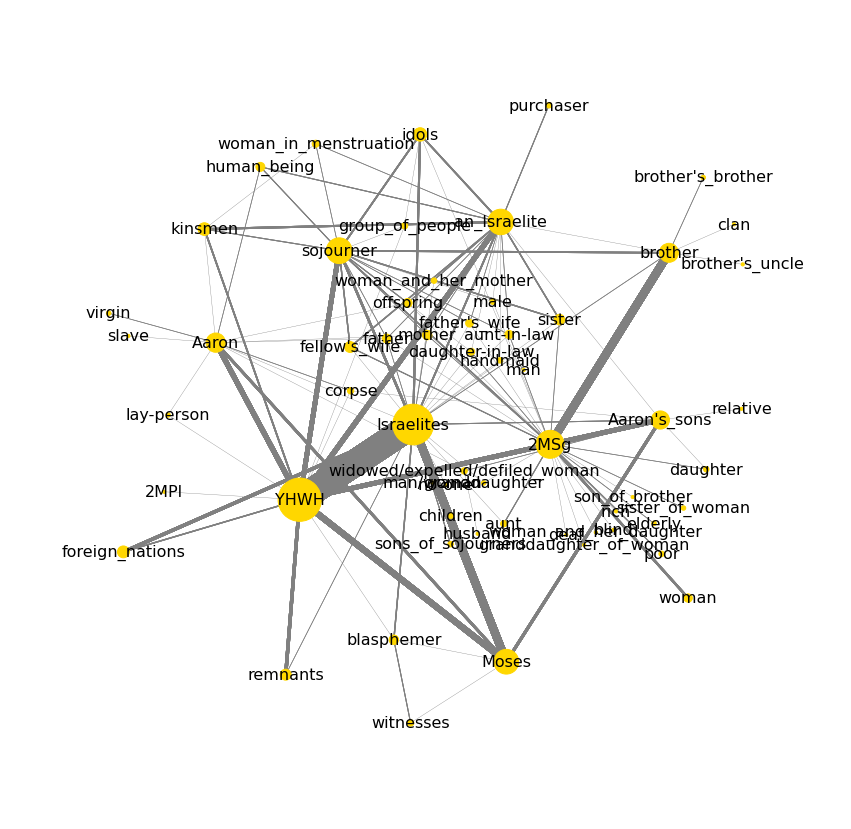

In [6]:
plt.figure(figsize = (15,15))

nx.draw_networkx(G, l, node_color='gold', node_size=[n[1]*10 for n in G.degree()], 
                 edge_color='grey', width=[d['weight']/3 for _, _, d in G.edges(data=True)], font_size=16)

plt.axis('off')
plt.margins(x=0.1, y=0.1)

plt.savefig('images/7.2.png', dpi=500)
plt.show()

Export for cover page:

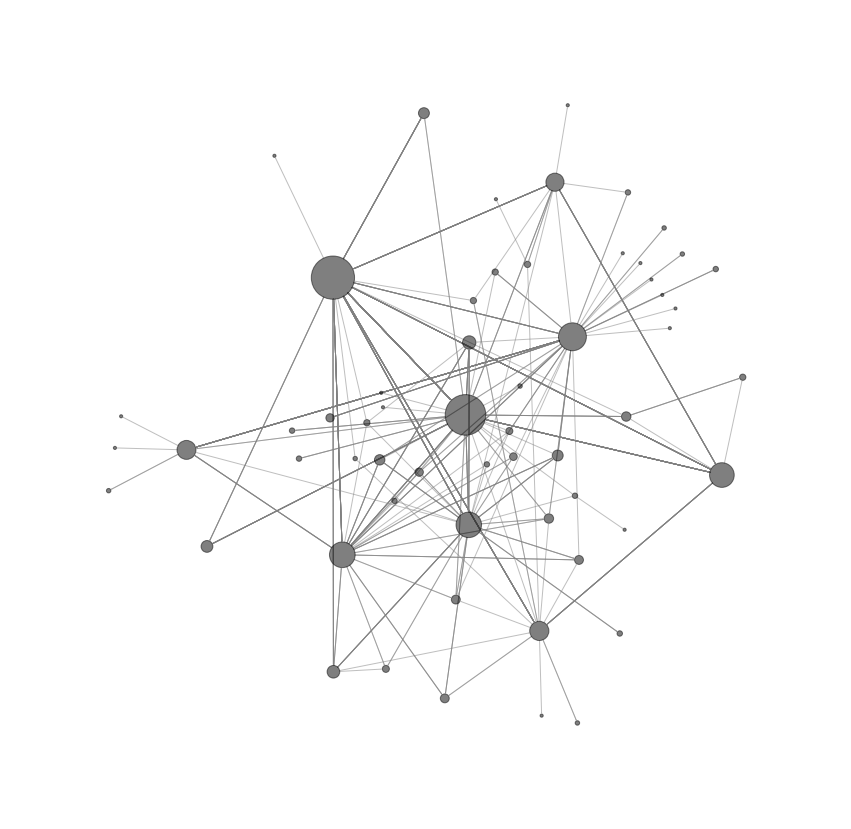

In [87]:
plt.figure(figsize = (15,15))

nx.draw_networkx(G, l, node_color='black', alpha=0.5, node_size=[n[1]*10 for n in G.degree()], 
                 edge_color='grey', font_size=16, with_labels=False, arrows=True, arrowsize=0.1)


plt.axis('off')
plt.margins(x=0.1, y=0.1)
plt.savefig('images/cover.png', dpi=500)
plt.show()

Number of nodes and edges:

In [ ]:
print(f'Nodes: {len(G.nodes())}\nEdges: {len(G.edges())}')

Having created the edges and computed a multiple directed graph (MultiDiGraph), we can now explore the resulting network. We will begin with a general inspection:

### 5.b Cohesion and network density

One of the simplest measures of cohession ("knittedness") is probably density. Density is simply the number of ties in the network proportional to the possible number of ties.

In [ ]:
G1 = nx.Graph()

for n, row in data.iterrows():  
    G1.add_edge(row.Source, row.Target)

In [ ]:
print(f'Number of edges: {len(G1.edges)}')

In [ ]:
nx.density(G1)

Density is sensitive to the size of the network, and large networks tend to have lower density than small networks, simply because it is more realistic for a member of a small network to be connected with most of the remaining participants than in a large network.

Therefore, another approach is average degree:

In [ ]:
degree = G.degree()
sum_degree = sum(dict(degree).values())
print(f'Average degree: {sum_degree/len(G.nodes())}')

In [ ]:
G = nx.MultiDiGraph()

for n, row in data.iterrows():  
    G.add_edge(row.Source, row.Target)

In [ ]:
outdegree_sequence = collections.Counter(sorted([d for n, d in G.out_degree()], reverse=True))
indegree_sequence = collections.Counter(sorted([d for n, d in G.in_degree()], reverse=True))

outdegree_df = pd.DataFrame(outdegree_sequence, index=[0]).T
indegree_df = pd.DataFrame([indegree_sequence]).T

In [ ]:
degree_df = pd.concat([indegree_df, outdegree_df], axis=1, sort=False)
degree_df.columns = ['indegree','outdegree']
degree_df

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))

plt.bar(degree_df.index, degree_df.indegree, width=0.33)
plt.bar(degree_df.index+0.33, degree_df.outdegree, color='tomato', width=0.33)

ax.legend(labels=['indegree', 'outdegree'], fontsize=14)
plt.ylabel("Count", size=14)
plt.xlabel("Degree", size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

Cumulative:

In [ ]:
len(G.nodes())

In [ ]:
indegree_cum = [n/len(G.nodes())*100 for n in np.cumsum(degree_df.fillna(0).indegree)]
outdegree_cum = [n/len(G.nodes())*100 for n in np.cumsum(degree_df.fillna(0).outdegree)]
degree_df.insert(2, "indegree_cum (%)", indegree_cum)
degree_df.insert(3, "outdegree_cum (%)", outdegree_cum)

In [ ]:
degree_df

Most connected participants:

In [ ]:
top_degree = sorted(dict(degree).items(), key=itemgetter(1), reverse=True)

A cummulative view:

In [ ]:
cum_degree = pd.DataFrame(top_degree)
cum_degree.columns = ['participant','degree']

degree_cum = [n/(len((G.edges()))*2)*100 for n in np.cumsum(cum_degree.degree)]
cum_degree.insert(2, "degree_cum (%)", degree_cum)

In [ ]:
cum_degree.head(10)

Updated graph:

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,7))
ax2 = ax1.twinx()
ax1.tick_params(axis='both', which='major', labelsize=16)

ax1.bar(degree_df.index, degree_df.indegree, width=0.33)
ax1.bar(degree_df.index+0.33, degree_df.outdegree, color='tomato', width=0.33)

ax2.plot(degree_df.index, degree_df['indegree_cum (%)'], linestyle='--', alpha=0.5, linewidth=2)
ax2.plot(degree_df.index, degree_df['outdegree_cum (%)'], linestyle='--', alpha=0.5, linewidth=2)

ax1.legend(frameon=1, labels=['indegree', 'outdegree'], fontsize=16, facecolor='white', framealpha=1, loc='right')
ax1.set_ylabel("Count", size=20)
ax2.set_ylabel("Cumulative %", size=20)
ax1.set_xlabel("")
plt.xticks(size=16)
plt.yticks(size=16)
plt.savefig(f'images/7.3.png', bbox_inches='tight', dpi=500)
plt.show()

Inspect values:

In [ ]:
G.degree()

In [ ]:
G.in_degree()

### 5.c Reciprocity

Reciprocity concerns whether an interaction from one actor to another is returned, or whether the relation is one-sided. A simple measure of reciprocity is to count the number of reciprocal ties and divide these by the total number of ties. For this analysis, we are not interested in the weights of the edges but simply the binary value (connected or not).

In [ ]:
digraph = nx.DiGraph()

for n, row in data.iterrows():
    digraph.add_edge(row.Source, row.Target)

In [ ]:
round(nx.reciprocity(digraph)*100, 2)

In [ ]:
reci_df = pd.DataFrame([nx.reciprocity(digraph, digraph.nodes())]).T.sort_values(by=0, ascending=False).head(30)

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

plt.bar(reci_df.index, reci_df[0])
plt.ylabel("fraction", size=20)
plt.xticks(size=16, rotation=45, ha='right')
plt.yticks(size=16)
plt.savefig(f'images/7.4.png', bbox_inches='tight', dpi=500)
plt.show()

In [ ]:
reci_df

### 5.d Centrality

We use 4 measures for measuring the centrality of individual nodes. That will give an image of core and periphery of the network. The four measures are Degree, Closeness, Betweenness, and Eigenvector.

In [ ]:
indegree = nx.in_degree_centrality(digraph)
outdegree = nx.out_degree_centrality(digraph)
betweenness = nx.betweenness_centrality(digraph)
pagerank = nx.pagerank(digraph)

In [ ]:
centrality = pd.DataFrame([indegree, outdegree, betweenness, pagerank]).T
centrality.columns = ['indegree','outdegree','betweeness','pagerank']
centrality

#### Top five scores for centrality measures:

In [ ]:
def top(measure, df=centrality):
    return df.sort_values(by=measure, ascending=False)[measure][:10]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,7), sharey=True)
fig.tight_layout(pad=1.0)

ax1.bar(top('outdegree').index, top('outdegree'))
ax1.set_title("Outdegree", size=22)
ax2.bar(top('indegree').index, top('indegree'))
ax2.set_title("Indegree", size=22)
ax3.bar(top('betweeness').index, top('betweeness'))
ax3.set_title("Betweenness", size=22)
ax4.bar(top('pagerank').index, top('pagerank'))
ax4.set_title("PageRank", size=22)

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45, ha='right', size=18)
    plt.yticks(size=18)

plt.savefig(f'images/7.5.png', bbox_inches='tight', dpi=500)
plt.show()